In [1]:
!pip install torchmetrics
!git clone https://github.com/EkagraGupta/MasterArbeit.git

Cloning into 'MasterArbeit'...
remote: Enumerating objects: 2107, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 2107 (delta 17), reused 21 (delta 9), pack-reused 2075 (from 1)
Receiving objects: 100% (2107/2107), 977.68 MiB | 37.03 MiB/s, done.
Resolving deltas: 100% (1042/1042), done.
Updating files: 100% (179/179), done.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

DATASET_NAME = 'CIFAR100'    # CIFAR10, CIFAR100
DATASET_TYPE = 'custom'   # baseline, custom
EPOCHS = 300
BATCH_SIZE = 512
ENABLE_TPU = False

# CIFAR-10-C
if DATASET_NAME=='CIFAR10':
    dataset_dir = '/kaggle/input/cifar-c'
    print(os.listdir(dataset_dir))
    # Define the path to the subdirectory
    sub_dir = os.path.join(dataset_dir, 'CIFAR-10-C')
    # List contents of the subdirectory
    print(os.listdir(sub_dir))
elif DATASET_NAME=='CIFAR100':
    # CIFAR-100-C
    dataset_dir = '/kaggle/input/cifar-100-c'
    print(os.listdir(dataset_dir))
else:
    raise ValueError(f'Dataset {DATASET_NAME} not supported')
    

print(f'Hyperparameters:\n\tDataset: {DATASET_NAME}\n\tType: {DATASET_TYPE}\n\tEpochs: {EPOCHS}\n\tTPU Enabled: {ENABLE_TPU}')

['motion_blur.npy', 'speckle_noise.npy', 'jpeg_compression.npy', 'impulse_noise.npy', 'defocus_blur.npy', 'brightness.npy', 'elastic_transform.npy', 'snow.npy', 'labels.npy', 'gaussian_blur.npy', 'README.txt', 'frost.npy', 'zoom_blur.npy', 'spatter.npy', 'fog.npy', 'gaussian_noise.npy', 'contrast.npy', 'saturate.npy', 'shot_noise.npy', 'pixelate.npy', 'glass_blur.npy']
Hyperparameters:
	Dataset: CIFAR100
	Type: custom
	Epochs: 300
	TPU Enabled: False


In [3]:
# Import statements
import torch
import random
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision.transforms import TrivialAugmentWide
from torch.utils.data import Dataset
from torch.utils.data import ConcatDataset
import os

# Define the device
tpu = ENABLE_TPU

if tpu == True:
    print('TPU is Enabled')
    import torch_xla
    import torch_xla.core.xla_model as xm
    device = xm.xla_device()
else:
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')  #intend here for else


class CustomDataset(Dataset):
    def __init__(self, np_images, original_dataset, resize):
        # Load images
        self.images = torch.from_numpy(np_images).permute(0, 3, 1, 2) / 255
         #Normalize the images
        #transform_test = transforms.Compose([
            #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        #])
        #self.images = transform_test(self.images)
        #if resize == True:
            #self.images = transforms.Resize(224, antialias=True)(self.images)
        
        # Extract labels from the original PyTorch dataset
        self.labels = [label for _, label in original_dataset]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        # Get image and label for the given index
        image = self.images[index]
        label = self.labels[index]

        return image, label

# Define the function to load corrupted datasets separately
def load_data_c_separately(dataset, testset, resize, test_transforms, batch_size):
    corruptions = ['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur', 'glass_blur', 'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog', 'brightness', 'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression', 'speckle_noise', 'gaussian_blur', 'spatter', 'saturate']
    np.asarray(corruptions)
    c_datasets = {}
    for corruption in corruptions:
        if dataset == 'CIFAR10':
            np_data_c = np.load(f'/kaggle/input/cifar-c/CIFAR-10-C/{corruption}.npy')
            np_data_c = np.array(np.array_split(np_data_c, 5))
            custom_dataset = CustomDataset(np_data_c[0], testset, resize)  # Load only one split for now
            custom_dataloader = torch.utils.data.DataLoader(custom_dataset, batch_size=batch_size, shuffle=False)
            c_datasets[corruption] = custom_dataloader
        else:
            print('No corrupted benchmark available other than CIFAR10-c.')

    return c_datasets


# Load corrupted datasets
#corrupted_datasets = load_data_c(dataset='CIFAR10', testset=testset, resize=True, 
                                 #test_transforms=None, subset=False, subsetsize=None)

# Transformations for training and test sets
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),  
    TrivialAugmentWide(),
    transforms.ToTensor(),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
])

batch_size = BATCH_SIZE

print(f'Loading {DATASET_NAME}...\n')
if DATASET_NAME=='CIFAR10':
#     Use CIFAR-10 dataset for training
    num_classes = 10    # CIFAR-10
    baseline_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform_train)
    baseline_trainloader = torch.utils.data.DataLoader(baseline_trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2, pin_memory=True)

    # Use CIFAR-10 dataset for testing
    baseline_testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)
    baseline_testloader = torch.utils.data.DataLoader(baseline_testset, batch_size=batch_size,
                                             shuffle=False, num_workers=2, pin_memory=True)
elif DATASET_NAME=='CIFAR100':
    # # Use CIFAR-100 dataset for training
    num_classes = 100   # CIFAR-100
    baseline_trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                            download=True, transform=transform_train)
    baseline_trainloader = torch.utils.data.DataLoader(baseline_trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2, pin_memory=True)

    # Use CIFAR-100 dataset for testing
    baseline_testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                           download=True, transform=transform_test)
    baseline_testloader = torch.utils.data.DataLoader(baseline_testset, batch_size=batch_size,
                                             shuffle=False, num_workers=2, pin_memory=True)
    
%cd /kaggle/working/MasterArbeit
from augment_dataset import create_transforms, load_data
from compute_loss import soft_loss

"""
 Create the transformations based on the provided flags:
 - If all flags (random_cropping, aggressive_augmentation, and custom) are False:
   No augmentation other than default preprocessing is applied.
 - If random_cropping (rc) is True and the others (aa and custom) are False:
   Only random cropping is applied.
 - If random_cropping (rc) and aggressive_augmentation (aa) are True, and custom is False:
   Random cropping and conventional aggressive augmentation techniques (TA) are applied.
 - If all three flags (rc, aa, custom) are True:
   Random cropping and soft augmentation techniques (TA) are applied.
 - If random_cropping (rc) is False, aggressive_augmentation (aa) is True, and custom is False:
   Only conventional aggressive augmentation techniques (TA) are applied (no soft labels).
 - If random_cropping (rc) is False, aggressive_augmentation (aa) is True, and custom is True:
   Aggressive augmentation (TA) is applied with soft labeling.
"""

transforms_preprocess, transforms_augmentation = create_transforms(random_cropping=False, aggressive_augmentation=True, custom=True, dataset_name=DATASET_NAME)
custom_trainset, custom_testset = load_data(transforms_preprocess=transforms_preprocess, transforms_augmentation=transforms_augmentation, dataset_name=DATASET_NAME)
custom_trainloader = torch.utils.data.DataLoader(custom_trainset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
custom_testloader = torch.utils.data.DataLoader(custom_testset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
%cd

classes = baseline_trainset.classes


Loading CIFAR100...



100%|██████████| 169001437/169001437 [00:03<00:00, 55364251.37it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
/kaggle/working/MasterArbeit


100%|██████████| 169001437/169001437 [00:02<00:00, 76511368.95it/s]


Extracting ./data/train/cifar-100-python.tar.gz to ./data/train


100%|██████████| 169001437/169001437 [00:02<00:00, 59079677.27it/s]


Extracting ./data/test/cifar-100-python.tar.gz to ./data/test
/root


In [4]:
print(transforms_augmentation)

Compose(
    RandomHorizontalFlip(p=0.5)
    RandomCrop(size=(32, 32), padding=4)
)


Dataset type "custom" displaying...

worm : 0.99 can  : 1.00 bear : 1.00 mouse: 0.75 bus  : 0.89 lizard: 1.00 plain: 0.75 lawn_mower: 0.81 cattle: 0.93 couch: 1.00 worm : 0.96 caterpillar: 1.00 rose : 0.98 cup  : 1.00 lion : 0.94 pickup_truck: 1.00 lion : 1.00 possum: 0.99 pear : 0.99 boy  : 0.93 couch: 0.75 plate: 0.96 raccoon: 1.00 lawn_mower: 0.81 skunk: 1.00 bee  : 1.00 snail: 0.96 tractor: 0.89 wardrobe: 0.98 wardrobe: 1.00 chair: 0.93 girl : 0.96 dinosaur: 1.00 chair: 0.93 tank : 0.99 butterfly: 0.86 chimpanzee: 0.83 skunk: 0.95 telephone: 1.00 orchid: 1.00 wolf : 0.96 mountain: 0.96 elephant: 0.86 seal : 0.80 house: 0.90 bicycle: 0.92 fox  : 1.00 sunflower: 0.96 plain: 0.89 wolf : 0.94 sea  : 0.90 crocodile: 0.92 crab : 1.00 kangaroo: 0.75 sea  : 0.80 tulip: 1.00 beetle: 1.00 dolphin: 0.98 wolf : 0.96 crocodile: 0.57 plate: 0.97 streetcar: 0.85 television: 0.81 dinosaur: 1.00 chair: 0.81 butterfly: 1.00 snail: 1.00 mushroom: 0.94 wardrobe: 0.92 man  : 0.99 worm : 0.98 crocodile:

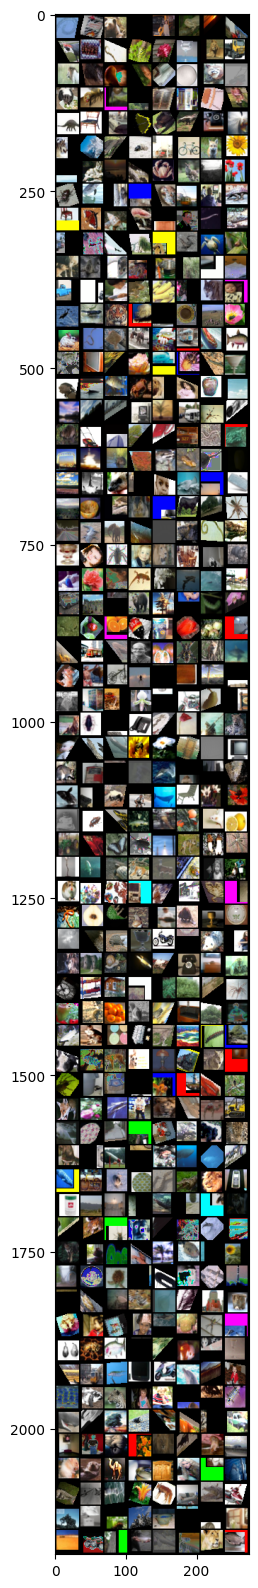

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.cpu().numpy()
    plt.figure(figsize=(25, 20))  # Adjust the width and height as needed
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
print(f'Dataset type "{DATASET_TYPE}" displaying...\n')

if DATASET_TYPE=='custom':
    dataiter = iter(custom_trainloader)
    images, labels, confidences = next(dataiter)
    # print labels 
    if isinstance(confidences, list):
        # in case we have confidence 
        confidences = confidences[1]
        
    print(' '.join(f'{classes[labels[j]]:5s}: {confidences[j].item():.2f}' for j in range(batch_size)))
elif DATASET_TYPE=='baseline':
#     if training baseline model
    dataiter = iter(baseline_trainloader)
    images, labels = next(dataiter)
    print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
else:
    raise ValueError(f'Dataset type {DATASET_TYPE} not supported')
    
# show images
imshow(torchvision.utils.make_grid(images))

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import numpy as np


# Manual implementation of ResNet18
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=num_classes):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling layer
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)  # Apply global average pooling
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out



# ResNet18 Architecture
def ResNet18(num_classes=num_classes):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

In [7]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=True)

def conv_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.xavier_uniform(m.weight, gain=np.sqrt(2))
        init.constant(m.bias, 0)
    elif classname.find('BatchNorm') != -1:
        init.constant(m.weight, 1)
        init.constant(m.bias, 0)

class WideBasic(nn.Module):
    def __init__(self, in_planes, planes, dropout_rate, stride=1):
        super(WideBasic, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, padding=1, bias=True)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=True),
            )

    def forward(self, x):
        out = self.dropout(self.conv1(F.relu(self.bn1(x))))
        out = self.conv2(F.relu(self.bn2(out)))
        out += self.shortcut(x)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class WideResNet(nn.Module):
    def __init__(self, depth, widen_factor, dropout_rate=0.3, num_classes=num_classes, factor=1, block=WideBasic):
        super(WideResNet, self).__init__()
        self.in_planes = 16

        assert ((depth-4)%6 ==0), 'Wide-resnet depth should be 6n+4'
        n = (int)((depth-4)/6)
        k = widen_factor

        nStages = [16, 16*k, 32*k, 64*k]

        self.conv1 = conv3x3(3,nStages[0], stride=1)
        self.layer1 = self._wide_layer(block, nStages[1], n, dropout_rate, stride=factor)
        self.layer2 = self._wide_layer(block, nStages[2], n, dropout_rate, stride=2)
        self.layer3 = self._wide_layer(block, nStages[3], n, dropout_rate, stride=2)
        self.bn1 = nn.BatchNorm2d(nStages[3], momentum=0.9)
        self.linear = nn.Linear(nStages[3], num_classes)

    def _wide_layer(self, block, planes, num_blocks, dropout_rate, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []

        for stride in strides:
            layers.append(block(self.in_planes, planes, dropout_rate, stride))
            self.in_planes = planes

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)

        return out

def WideResNet_28_4(num_classes, factor=1, block=WideBasic, dropout_rate=0.3):
    return WideResNet(depth=28, widen_factor=4, dropout_rate=dropout_rate, num_classes=num_classes, factor=factor, block=block)

def WideResNet_28_10(num_classes, factor=1, block=WideBasic, dropout_rate=0.0):
    return WideResNet(depth=28, widen_factor=10, dropout_rate=dropout_rate, num_classes=num_classes, factor=factor, block=block)

## Model Training

In [8]:
# Initialize the model
net = WideResNet_28_4(num_classes=num_classes)
# net = WideResNet_28_10(num_classes=num_classes)
net.to(device)

WideResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer1): Sequential(
    (0): WideBasic(
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout): Dropout(p=0.3, inplace=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential(
        (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (1): WideBasic(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout): Dropout(p=0.3, inplace=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, ke

In [9]:
def soft_loss(pred, label, confidence):
    log_prob = F.log_softmax(pred, dim=1)
    # print(f'log_prob: {log_prob.shape}')
    n_class = pred.size(1)

    # Make soft one-hot target
    label = label.unsqueeze(1)
    # print(f'label: {label.shape}')
    confidence = confidence.unsqueeze(1).float()
    # print(f'confidence: {confidence.shape}')
    one_hot = torch.ones_like(pred) * (1 - confidence) / (n_class - 1)
    # print(f'one_hot: {one_hot.shape}')
    one_hot.scatter_(dim=1, index=label, src=confidence)
    # print(f'one_hot: {one_hot.shape}')

    # Compute weighted KL loss
    kl_uw = F.kl_div(input=log_prob, target=one_hot, reduction="none").sum(-1)
    kl_uw = kl_uw.unsqueeze(1)
    # print(f'kl_unweighted: {kl_uw.shape}')                   # Unweighted
    kl = confidence * kl_uw  # Weighted
    # print(f'kl: {kl.shape}')
    return kl.mean()

In [10]:
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
import time

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.15, momentum=0.9, weight_decay=1e-4)

# Initialize the scheduler
epochs = EPOCHS
scheduler = CosineAnnealingLR(optimizer, T_max=epochs)  # Cosine Annealing LR Scheduler

# For plotting
train_losses, test_accuracies = [], []

# Training loop
print(f'\nStart Training...\n')
for epoch in range(epochs):  # loop over the dataset multiple times
    
    start_time = time.time()
    
    running_loss = 0.0
    total_train = 0
    correct_train = 0
    total = 0
    correct = 0
    confidences = None
    
    net.train()
    
    # for i, (inputs, labels) in enumerate(baseline_trainloader):
    for i, (inputs, labels, confidences) in enumerate(custom_trainloader):
        if DATASET_TYPE=='custom' and confidences is None:
            raise ValueError('Dataset type do not match data loader')
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        """when the model returns [augmentation_magnitude, confidence_aa], which is the case
        only when TA with soft labels is applied."""
            
        # get the inputs
        if isinstance(confidences, list):
            confidences = confidences[1]
            
        confidences = confidences.to(device)
        
        inputs, labels = inputs.to(device), labels.to(device)
    
        # Convert labels to one-hot encoded vectors
        # labels_one_hot = F.one_hot(labels, num_classes=10).float()
        
        # forward + backward + optimize
        outputs = net(inputs)
        
        if DATASET_TYPE=='custom':
            loss = soft_loss(pred=outputs, label=labels, confidence=confidences)
#             loss = smooth_crossentropy(pred=outputs, gold=labels)
        else:
            loss = criterion(outputs, labels)
            
        # Check for correct training
        if np.isnan(loss.detach().cpu().numpy()):
            raise ValueError('Loss calculation not correct')
    
        loss.backward()
        optimizer.step()
        if tpu:
            xm.mark_step()
        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    with torch.no_grad():
        net.eval()
        for images, labels in baseline_testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # calculate and print average loss for current epoch
    average_loss = running_loss / len(custom_trainloader)
    train_losses.append(average_loss)
    
    test_accuracy = correct / total
    test_accuracies.append(test_accuracy)
    
    print(f'\nEpoch {epoch + 1} - Loss: {average_loss:.3f} - Test Accuracy: {100 * test_accuracy: .3f}')    
    
    scheduler.step()
    end_time = time.time()
    print(f'\nProcessing time: {(end_time - start_time): 3f} seconds.')

print('Finished Training')

# Save the trained model
PATH = f'/kaggle/working/{DATASET_NAME}_net_ta_{DATASET_TYPE}_{epochs}.pth'
torch.save(net.state_dict(), PATH)


Start Training...



/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 1 - Loss: 3.576 - Test Accuracy:  5.120

Processing time:  48.492382 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 2 - Loss: 3.273 - Test Accuracy:  8.040

Processing time:  47.389550 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 3 - Loss: 3.107 - Test Accuracy:  13.340

Processing time:  47.390358 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 4 - Loss: 2.879 - Test Accuracy:  20.490

Processing time:  47.393365 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 5 - Loss: 2.691 - Test Accuracy:  19.720

Processing time:  47.370447 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 6 - Loss: 2.530 - Test Accuracy:  26.460

Processing time:  47.368813 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 7 - Loss: 2.393 - Test Accuracy:  21.190

Processing time:  47.363590 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 8 - Loss: 2.239 - Test Accuracy:  26.350

Processing time:  47.369882 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 9 - Loss: 2.134 - Test Accuracy:  30.830

Processing time:  47.381641 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 10 - Loss: 2.041 - Test Accuracy:  22.480

Processing time:  47.385437 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 11 - Loss: 1.953 - Test Accuracy:  34.230

Processing time:  47.354776 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 12 - Loss: 1.879 - Test Accuracy:  41.940

Processing time:  47.377369 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 13 - Loss: 1.817 - Test Accuracy:  41.990

Processing time:  47.384130 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 14 - Loss: 1.755 - Test Accuracy:  42.070

Processing time:  47.380792 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 15 - Loss: 1.698 - Test Accuracy:  45.690

Processing time:  47.360028 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 16 - Loss: 1.651 - Test Accuracy:  42.000

Processing time:  47.363472 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 17 - Loss: 1.607 - Test Accuracy:  48.740

Processing time:  47.375636 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 18 - Loss: 1.573 - Test Accuracy:  45.390

Processing time:  47.480874 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 19 - Loss: 1.522 - Test Accuracy:  47.540

Processing time:  47.381819 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 20 - Loss: 1.482 - Test Accuracy:  45.650

Processing time:  47.352554 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 21 - Loss: 1.455 - Test Accuracy:  50.170

Processing time:  47.369946 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 22 - Loss: 1.442 - Test Accuracy:  57.360

Processing time:  47.385680 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 23 - Loss: 1.410 - Test Accuracy:  50.530

Processing time:  47.363899 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 24 - Loss: 1.381 - Test Accuracy:  55.650

Processing time:  47.373407 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 25 - Loss: 1.363 - Test Accuracy:  54.060

Processing time:  47.356582 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 26 - Loss: 1.331 - Test Accuracy:  59.200

Processing time:  47.351862 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 27 - Loss: 1.311 - Test Accuracy:  54.490

Processing time:  47.369771 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 28 - Loss: 1.286 - Test Accuracy:  60.090

Processing time:  47.378604 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 29 - Loss: 1.278 - Test Accuracy:  57.440

Processing time:  47.375898 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 30 - Loss: 1.246 - Test Accuracy:  59.760

Processing time:  47.359151 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 31 - Loss: 1.233 - Test Accuracy:  62.140

Processing time:  47.396039 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 32 - Loss: 1.216 - Test Accuracy:  59.970

Processing time:  47.380440 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 33 - Loss: 1.199 - Test Accuracy:  60.700

Processing time:  47.365298 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 34 - Loss: 1.189 - Test Accuracy:  60.110

Processing time:  47.379717 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 35 - Loss: 1.174 - Test Accuracy:  60.870

Processing time:  47.338055 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 36 - Loss: 1.156 - Test Accuracy:  64.880

Processing time:  47.332482 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 37 - Loss: 1.140 - Test Accuracy:  62.880

Processing time:  47.400304 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 38 - Loss: 1.133 - Test Accuracy:  62.340

Processing time:  47.348794 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 39 - Loss: 1.115 - Test Accuracy:  62.830

Processing time:  47.385700 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 40 - Loss: 1.110 - Test Accuracy:  61.080

Processing time:  47.377211 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 41 - Loss: 1.092 - Test Accuracy:  63.650

Processing time:  47.402502 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 42 - Loss: 1.081 - Test Accuracy:  64.290

Processing time:  47.406281 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 43 - Loss: 1.070 - Test Accuracy:  64.210

Processing time:  47.384070 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 44 - Loss: 1.066 - Test Accuracy:  64.180

Processing time:  47.370353 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 45 - Loss: 1.051 - Test Accuracy:  64.910

Processing time:  47.383738 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 46 - Loss: 1.049 - Test Accuracy:  66.440

Processing time:  47.364903 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 47 - Loss: 1.037 - Test Accuracy:  64.190

Processing time:  47.374464 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 48 - Loss: 1.029 - Test Accuracy:  67.480

Processing time:  47.356942 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 49 - Loss: 1.026 - Test Accuracy:  67.940

Processing time:  47.393669 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 50 - Loss: 1.025 - Test Accuracy:  67.580

Processing time:  47.400964 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 51 - Loss: 1.007 - Test Accuracy:  65.650

Processing time:  47.359735 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 52 - Loss: 1.002 - Test Accuracy:  68.560

Processing time:  47.395595 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 53 - Loss: 0.990 - Test Accuracy:  67.760

Processing time:  47.422314 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 54 - Loss: 0.986 - Test Accuracy:  69.100

Processing time:  47.413375 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 55 - Loss: 0.978 - Test Accuracy:  63.970

Processing time:  47.387866 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 56 - Loss: 0.970 - Test Accuracy:  65.980

Processing time:  47.373633 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 57 - Loss: 0.960 - Test Accuracy:  66.360

Processing time:  47.397939 seconds.

Epoch 58 - Loss: 0.958 - Test Accuracy:  68.480

Processing time:  47.392010 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 59 - Loss: 0.956 - Test Accuracy:  68.220

Processing time:  47.353657 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 60 - Loss: 0.941 - Test Accuracy:  63.650

Processing time:  47.405236 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 61 - Loss: 0.934 - Test Accuracy:  67.540

Processing time:  47.433260 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 62 - Loss: 0.927 - Test Accuracy:  66.550

Processing time:  47.406967 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 63 - Loss: 0.933 - Test Accuracy:  67.460

Processing time:  47.401424 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 64 - Loss: 0.906 - Test Accuracy:  68.600

Processing time:  47.388716 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 65 - Loss: 0.918 - Test Accuracy:  69.270

Processing time:  47.430566 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 66 - Loss: 0.918 - Test Accuracy:  69.510

Processing time:  47.394776 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 67 - Loss: 0.897 - Test Accuracy:  70.010

Processing time:  47.384422 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 68 - Loss: 0.899 - Test Accuracy:  67.980

Processing time:  47.377809 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 69 - Loss: 0.888 - Test Accuracy:  67.300

Processing time:  47.394774 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 70 - Loss: 0.882 - Test Accuracy:  68.730

Processing time:  47.390285 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 71 - Loss: 0.886 - Test Accuracy:  68.700

Processing time:  47.373051 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 72 - Loss: 0.883 - Test Accuracy:  68.900

Processing time:  47.422101 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 73 - Loss: 0.872 - Test Accuracy:  69.930

Processing time:  47.398867 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 74 - Loss: 0.870 - Test Accuracy:  69.990

Processing time:  47.369361 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 75 - Loss: 0.870 - Test Accuracy:  68.880

Processing time:  47.379766 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 76 - Loss: 0.874 - Test Accuracy:  70.460

Processing time:  47.407247 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 77 - Loss: 0.852 - Test Accuracy:  69.320

Processing time:  47.384921 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 78 - Loss: 0.846 - Test Accuracy:  69.820

Processing time:  47.369052 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 79 - Loss: 0.841 - Test Accuracy:  70.750

Processing time:  47.366539 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 80 - Loss: 0.843 - Test Accuracy:  69.690

Processing time:  47.385094 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 81 - Loss: 0.839 - Test Accuracy:  70.670

Processing time:  47.367395 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 82 - Loss: 0.827 - Test Accuracy:  68.950

Processing time:  47.395007 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 83 - Loss: 0.828 - Test Accuracy:  70.160

Processing time:  47.426425 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 84 - Loss: 0.834 - Test Accuracy:  70.850

Processing time:  47.374031 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 85 - Loss: 0.823 - Test Accuracy:  69.470

Processing time:  47.362782 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 86 - Loss: 0.814 - Test Accuracy:  70.180

Processing time:  47.373639 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 87 - Loss: 0.818 - Test Accuracy:  71.220

Processing time:  47.374252 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 88 - Loss: 0.826 - Test Accuracy:  71.840

Processing time:  47.359709 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 89 - Loss: 0.810 - Test Accuracy:  67.390

Processing time:  47.364796 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 90 - Loss: 0.796 - Test Accuracy:  69.980

Processing time:  47.370074 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 91 - Loss: 0.794 - Test Accuracy:  70.650

Processing time:  47.371544 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 92 - Loss: 0.800 - Test Accuracy:  69.410

Processing time:  47.355139 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 93 - Loss: 0.791 - Test Accuracy:  72.010

Processing time:  47.362481 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 94 - Loss: 0.782 - Test Accuracy:  70.860

Processing time:  47.364049 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 95 - Loss: 0.790 - Test Accuracy:  70.590

Processing time:  47.366590 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 96 - Loss: 0.779 - Test Accuracy:  70.730

Processing time:  47.380831 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 97 - Loss: 0.779 - Test Accuracy:  68.330

Processing time:  47.373195 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 98 - Loss: 0.781 - Test Accuracy:  71.980

Processing time:  47.367366 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 99 - Loss: 0.769 - Test Accuracy:  72.090

Processing time:  47.387956 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 100 - Loss: 0.768 - Test Accuracy:  71.640

Processing time:  47.388759 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 101 - Loss: 0.766 - Test Accuracy:  72.150

Processing time:  47.354105 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 102 - Loss: 0.767 - Test Accuracy:  70.090

Processing time:  47.452586 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 103 - Loss: 0.749 - Test Accuracy:  71.260

Processing time:  47.363255 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 104 - Loss: 0.753 - Test Accuracy:  70.770

Processing time:  47.358429 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 105 - Loss: 0.752 - Test Accuracy:  71.480

Processing time:  47.366801 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 106 - Loss: 0.746 - Test Accuracy:  69.730

Processing time:  47.373305 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 107 - Loss: 0.746 - Test Accuracy:  71.420

Processing time:  47.370236 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 108 - Loss: 0.737 - Test Accuracy:  69.910

Processing time:  47.370634 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 109 - Loss: 0.735 - Test Accuracy:  71.100

Processing time:  47.371362 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 110 - Loss: 0.738 - Test Accuracy:  72.020

Processing time:  47.391645 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 111 - Loss: 0.733 - Test Accuracy:  71.670

Processing time:  47.378921 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 112 - Loss: 0.730 - Test Accuracy:  72.540

Processing time:  47.385924 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 113 - Loss: 0.722 - Test Accuracy:  72.710

Processing time:  47.375648 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 114 - Loss: 0.713 - Test Accuracy:  70.710

Processing time:  47.379622 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 115 - Loss: 0.725 - Test Accuracy:  72.740

Processing time:  47.406796 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 116 - Loss: 0.705 - Test Accuracy:  72.030

Processing time:  47.400519 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 117 - Loss: 0.715 - Test Accuracy:  71.700

Processing time:  47.387755 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 118 - Loss: 0.716 - Test Accuracy:  71.750

Processing time:  47.367332 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 119 - Loss: 0.708 - Test Accuracy:  72.180

Processing time:  47.375978 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 120 - Loss: 0.704 - Test Accuracy:  72.610

Processing time:  47.371162 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 121 - Loss: 0.697 - Test Accuracy:  70.550

Processing time:  47.404265 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 122 - Loss: 0.693 - Test Accuracy:  73.460

Processing time:  47.393843 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 123 - Loss: 0.699 - Test Accuracy:  72.750

Processing time:  47.378649 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 124 - Loss: 0.689 - Test Accuracy:  71.300

Processing time:  47.388832 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 125 - Loss: 0.687 - Test Accuracy:  74.200

Processing time:  47.395716 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 126 - Loss: 0.674 - Test Accuracy:  72.880

Processing time:  47.368994 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 127 - Loss: 0.684 - Test Accuracy:  74.020

Processing time:  47.404003 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 128 - Loss: 0.684 - Test Accuracy:  72.230

Processing time:  47.369996 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 129 - Loss: 0.675 - Test Accuracy:  71.710

Processing time:  47.407092 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 130 - Loss: 0.677 - Test Accuracy:  73.360

Processing time:  47.378338 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 131 - Loss: 0.664 - Test Accuracy:  70.890

Processing time:  47.406573 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 132 - Loss: 0.674 - Test Accuracy:  71.730

Processing time:  47.355100 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 133 - Loss: 0.666 - Test Accuracy:  73.290

Processing time:  47.397116 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 134 - Loss: 0.660 - Test Accuracy:  73.340

Processing time:  47.367365 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 135 - Loss: 0.655 - Test Accuracy:  73.180

Processing time:  47.364598 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 136 - Loss: 0.657 - Test Accuracy:  72.520

Processing time:  47.363288 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 137 - Loss: 0.653 - Test Accuracy:  70.890

Processing time:  47.346959 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 138 - Loss: 0.657 - Test Accuracy:  73.340

Processing time:  47.343977 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 139 - Loss: 0.650 - Test Accuracy:  72.900

Processing time:  47.409385 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 140 - Loss: 0.646 - Test Accuracy:  73.270

Processing time:  47.359410 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 141 - Loss: 0.644 - Test Accuracy:  73.850

Processing time:  47.418684 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 142 - Loss: 0.643 - Test Accuracy:  73.510

Processing time:  47.362171 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 143 - Loss: 0.643 - Test Accuracy:  74.180

Processing time:  47.402431 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 144 - Loss: 0.641 - Test Accuracy:  73.440

Processing time:  47.354216 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 145 - Loss: 0.634 - Test Accuracy:  75.300

Processing time:  47.369418 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 146 - Loss: 0.632 - Test Accuracy:  73.590

Processing time:  47.323028 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 147 - Loss: 0.634 - Test Accuracy:  73.430

Processing time:  47.394344 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 148 - Loss: 0.627 - Test Accuracy:  73.390

Processing time:  47.345159 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 149 - Loss: 0.618 - Test Accuracy:  74.800

Processing time:  47.406030 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 150 - Loss: 0.619 - Test Accuracy:  73.060

Processing time:  47.332268 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 151 - Loss: 0.616 - Test Accuracy:  72.410

Processing time:  47.375475 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 152 - Loss: 0.608 - Test Accuracy:  74.750

Processing time:  47.341702 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 153 - Loss: 0.613 - Test Accuracy:  73.450

Processing time:  47.326970 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 154 - Loss: 0.607 - Test Accuracy:  73.710

Processing time:  47.328543 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 155 - Loss: 0.608 - Test Accuracy:  74.010

Processing time:  47.331029 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 156 - Loss: 0.604 - Test Accuracy:  75.180

Processing time:  47.342233 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 157 - Loss: 0.606 - Test Accuracy:  74.090

Processing time:  47.339343 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 158 - Loss: 0.597 - Test Accuracy:  74.330

Processing time:  47.341597 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 159 - Loss: 0.598 - Test Accuracy:  75.480

Processing time:  47.386412 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 160 - Loss: 0.594 - Test Accuracy:  74.480

Processing time:  47.347665 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 161 - Loss: 0.587 - Test Accuracy:  73.840

Processing time:  47.361515 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 162 - Loss: 0.586 - Test Accuracy:  74.740

Processing time:  47.358831 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 163 - Loss: 0.583 - Test Accuracy:  73.290

Processing time:  47.377427 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 164 - Loss: 0.580 - Test Accuracy:  74.870

Processing time:  47.369432 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 165 - Loss: 0.575 - Test Accuracy:  74.940

Processing time:  47.368275 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 166 - Loss: 0.580 - Test Accuracy:  74.820

Processing time:  47.459290 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 167 - Loss: 0.578 - Test Accuracy:  73.900

Processing time:  47.346450 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 168 - Loss: 0.572 - Test Accuracy:  75.700

Processing time:  47.371582 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 169 - Loss: 0.563 - Test Accuracy:  74.380

Processing time:  47.359545 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 170 - Loss: 0.563 - Test Accuracy:  76.290

Processing time:  47.504156 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 171 - Loss: 0.561 - Test Accuracy:  75.430

Processing time:  47.337856 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 172 - Loss: 0.558 - Test Accuracy:  75.230

Processing time:  47.349095 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 173 - Loss: 0.558 - Test Accuracy:  74.830

Processing time:  47.346741 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 174 - Loss: 0.559 - Test Accuracy:  74.600

Processing time:  47.520048 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 175 - Loss: 0.552 - Test Accuracy:  74.890

Processing time:  47.341267 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 176 - Loss: 0.552 - Test Accuracy:  73.910

Processing time:  47.544159 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 177 - Loss: 0.552 - Test Accuracy:  76.100

Processing time:  47.360121 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 178 - Loss: 0.546 - Test Accuracy:  75.920

Processing time:  47.501456 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 179 - Loss: 0.544 - Test Accuracy:  76.070

Processing time:  47.383099 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 180 - Loss: 0.542 - Test Accuracy:  76.120

Processing time:  47.443176 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 181 - Loss: 0.543 - Test Accuracy:  76.120

Processing time:  47.376974 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 182 - Loss: 0.537 - Test Accuracy:  75.080

Processing time:  47.365960 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 183 - Loss: 0.524 - Test Accuracy:  76.350

Processing time:  47.356391 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 184 - Loss: 0.536 - Test Accuracy:  76.800

Processing time:  47.379051 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 185 - Loss: 0.533 - Test Accuracy:  75.980

Processing time:  47.357359 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 186 - Loss: 0.521 - Test Accuracy:  75.100

Processing time:  47.390640 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 187 - Loss: 0.523 - Test Accuracy:  75.620

Processing time:  47.338954 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 188 - Loss: 0.517 - Test Accuracy:  75.340

Processing time:  47.402105 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 189 - Loss: 0.515 - Test Accuracy:  74.990

Processing time:  47.365883 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 190 - Loss: 0.514 - Test Accuracy:  75.380

Processing time:  47.383703 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 191 - Loss: 0.515 - Test Accuracy:  76.890

Processing time:  47.374296 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 192 - Loss: 0.505 - Test Accuracy:  77.050

Processing time:  47.375756 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 193 - Loss: 0.503 - Test Accuracy:  76.570

Processing time:  47.373887 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 194 - Loss: 0.501 - Test Accuracy:  76.430

Processing time:  47.376123 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 195 - Loss: 0.504 - Test Accuracy:  75.890

Processing time:  47.355846 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 196 - Loss: 0.503 - Test Accuracy:  76.580

Processing time:  47.350135 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 197 - Loss: 0.493 - Test Accuracy:  76.820

Processing time:  47.398713 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 198 - Loss: 0.504 - Test Accuracy:  76.250

Processing time:  47.362932 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 199 - Loss: 0.491 - Test Accuracy:  76.610

Processing time:  47.391988 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 200 - Loss: 0.490 - Test Accuracy:  75.700

Processing time:  47.368279 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 201 - Loss: 0.490 - Test Accuracy:  75.410

Processing time:  47.361652 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 202 - Loss: 0.493 - Test Accuracy:  76.400

Processing time:  47.354183 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 203 - Loss: 0.482 - Test Accuracy:  76.910

Processing time:  47.358021 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 204 - Loss: 0.480 - Test Accuracy:  76.130

Processing time:  47.376344 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 205 - Loss: 0.482 - Test Accuracy:  77.530

Processing time:  47.387623 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 206 - Loss: 0.481 - Test Accuracy:  77.140

Processing time:  47.360171 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 207 - Loss: 0.479 - Test Accuracy:  76.450

Processing time:  47.335887 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 208 - Loss: 0.480 - Test Accuracy:  77.660

Processing time:  47.325455 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 209 - Loss: 0.471 - Test Accuracy:  77.000

Processing time:  47.331200 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 210 - Loss: 0.461 - Test Accuracy:  77.650

Processing time:  47.348861 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 211 - Loss: 0.464 - Test Accuracy:  77.300

Processing time:  47.358167 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 212 - Loss: 0.469 - Test Accuracy:  77.040

Processing time:  47.391484 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 213 - Loss: 0.462 - Test Accuracy:  77.330

Processing time:  47.334589 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 214 - Loss: 0.458 - Test Accuracy:  77.480

Processing time:  47.366369 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 215 - Loss: 0.455 - Test Accuracy:  77.490

Processing time:  47.355426 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 216 - Loss: 0.453 - Test Accuracy:  77.720

Processing time:  47.360714 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 217 - Loss: 0.455 - Test Accuracy:  78.000

Processing time:  47.356664 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 218 - Loss: 0.456 - Test Accuracy:  77.320

Processing time:  47.377527 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 219 - Loss: 0.451 - Test Accuracy:  78.270

Processing time:  47.359371 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 220 - Loss: 0.447 - Test Accuracy:  77.900

Processing time:  47.399445 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 221 - Loss: 0.446 - Test Accuracy:  78.110

Processing time:  47.374648 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 222 - Loss: 0.443 - Test Accuracy:  77.960

Processing time:  47.365760 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 223 - Loss: 0.439 - Test Accuracy:  78.340

Processing time:  47.358116 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 224 - Loss: 0.443 - Test Accuracy:  78.290

Processing time:  47.372814 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 225 - Loss: 0.433 - Test Accuracy:  78.080

Processing time:  47.370107 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 226 - Loss: 0.436 - Test Accuracy:  78.000

Processing time:  47.372253 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 227 - Loss: 0.429 - Test Accuracy:  78.400

Processing time:  47.375133 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 228 - Loss: 0.431 - Test Accuracy:  78.230

Processing time:  47.354759 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 229 - Loss: 0.428 - Test Accuracy:  77.840

Processing time:  47.382554 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 230 - Loss: 0.424 - Test Accuracy:  78.430

Processing time:  47.360559 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 231 - Loss: 0.430 - Test Accuracy:  78.170

Processing time:  47.427046 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 232 - Loss: 0.422 - Test Accuracy:  78.490

Processing time:  47.353067 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 233 - Loss: 0.421 - Test Accuracy:  78.480

Processing time:  47.358253 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 234 - Loss: 0.416 - Test Accuracy:  78.630

Processing time:  47.349367 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 235 - Loss: 0.414 - Test Accuracy:  79.000

Processing time:  47.386662 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 236 - Loss: 0.412 - Test Accuracy:  78.860

Processing time:  47.363188 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 237 - Loss: 0.412 - Test Accuracy:  78.900

Processing time:  47.374920 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 238 - Loss: 0.410 - Test Accuracy:  78.640

Processing time:  47.381191 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 239 - Loss: 0.409 - Test Accuracy:  78.640

Processing time:  47.411690 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 240 - Loss: 0.409 - Test Accuracy:  78.950

Processing time:  47.385700 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 241 - Loss: 0.407 - Test Accuracy:  79.380

Processing time:  47.356379 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 242 - Loss: 0.402 - Test Accuracy:  79.030

Processing time:  47.384256 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 243 - Loss: 0.404 - Test Accuracy:  79.090

Processing time:  47.381195 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 244 - Loss: 0.400 - Test Accuracy:  78.720

Processing time:  47.361182 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 245 - Loss: 0.401 - Test Accuracy:  79.100

Processing time:  47.362751 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 246 - Loss: 0.396 - Test Accuracy:  79.220

Processing time:  47.369720 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 247 - Loss: 0.395 - Test Accuracy:  79.200

Processing time:  47.364959 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 248 - Loss: 0.393 - Test Accuracy:  79.180

Processing time:  47.387132 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 249 - Loss: 0.392 - Test Accuracy:  78.720

Processing time:  47.374614 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 250 - Loss: 0.391 - Test Accuracy:  78.880

Processing time:  47.384353 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 251 - Loss: 0.391 - Test Accuracy:  78.700

Processing time:  47.366419 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 252 - Loss: 0.393 - Test Accuracy:  79.150

Processing time:  47.369379 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 253 - Loss: 0.384 - Test Accuracy:  79.100

Processing time:  47.337068 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 254 - Loss: 0.381 - Test Accuracy:  79.040

Processing time:  47.437152 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 255 - Loss: 0.389 - Test Accuracy:  79.410

Processing time:  47.327498 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 256 - Loss: 0.386 - Test Accuracy:  78.990

Processing time:  47.428362 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 257 - Loss: 0.389 - Test Accuracy:  79.180

Processing time:  47.352664 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 258 - Loss: 0.378 - Test Accuracy:  78.950

Processing time:  47.369585 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 259 - Loss: 0.380 - Test Accuracy:  79.080

Processing time:  47.367378 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 260 - Loss: 0.379 - Test Accuracy:  78.940

Processing time:  47.477212 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 261 - Loss: 0.374 - Test Accuracy:  79.030

Processing time:  47.359759 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 262 - Loss: 0.379 - Test Accuracy:  78.840

Processing time:  47.475646 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 263 - Loss: 0.378 - Test Accuracy:  79.270

Processing time:  47.362852 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 264 - Loss: 0.375 - Test Accuracy:  78.740

Processing time:  47.367674 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 265 - Loss: 0.371 - Test Accuracy:  78.830

Processing time:  47.376820 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 266 - Loss: 0.369 - Test Accuracy:  79.270

Processing time:  47.371322 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 267 - Loss: 0.373 - Test Accuracy:  79.140

Processing time:  47.350398 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 268 - Loss: 0.374 - Test Accuracy:  79.460

Processing time:  47.368795 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 269 - Loss: 0.370 - Test Accuracy:  79.520

Processing time:  47.371372 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 270 - Loss: 0.372 - Test Accuracy:  79.580

Processing time:  47.352146 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 271 - Loss: 0.371 - Test Accuracy:  79.300

Processing time:  47.373520 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 272 - Loss: 0.368 - Test Accuracy:  79.510

Processing time:  47.298467 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 273 - Loss: 0.364 - Test Accuracy:  79.680

Processing time:  47.304542 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 274 - Loss: 0.370 - Test Accuracy:  79.490

Processing time:  47.310937 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 275 - Loss: 0.361 - Test Accuracy:  79.760

Processing time:  47.310002 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 276 - Loss: 0.362 - Test Accuracy:  79.800

Processing time:  47.329989 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 277 - Loss: 0.369 - Test Accuracy:  79.710

Processing time:  47.282359 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 278 - Loss: 0.367 - Test Accuracy:  79.730

Processing time:  47.260076 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 279 - Loss: 0.366 - Test Accuracy:  79.650

Processing time:  47.268852 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 280 - Loss: 0.364 - Test Accuracy:  79.720

Processing time:  47.305158 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 281 - Loss: 0.358 - Test Accuracy:  79.830

Processing time:  47.289743 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 282 - Loss: 0.363 - Test Accuracy:  79.740

Processing time:  47.305952 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 283 - Loss: 0.364 - Test Accuracy:  79.780

Processing time:  47.269543 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 284 - Loss: 0.358 - Test Accuracy:  79.880

Processing time:  47.275896 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 285 - Loss: 0.363 - Test Accuracy:  79.820

Processing time:  47.299734 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 286 - Loss: 0.364 - Test Accuracy:  79.740

Processing time:  47.308863 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 287 - Loss: 0.359 - Test Accuracy:  79.630

Processing time:  47.338244 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 288 - Loss: 0.361 - Test Accuracy:  79.760

Processing time:  47.308589 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 289 - Loss: 0.361 - Test Accuracy:  79.650

Processing time:  47.392540 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 290 - Loss: 0.365 - Test Accuracy:  79.690

Processing time:  47.271109 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 291 - Loss: 0.363 - Test Accuracy:  79.840

Processing time:  47.303398 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 292 - Loss: 0.361 - Test Accuracy:  79.810

Processing time:  47.321313 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 293 - Loss: 0.360 - Test Accuracy:  79.840

Processing time:  47.428420 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 294 - Loss: 0.361 - Test Accuracy:  79.880

Processing time:  47.267776 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 295 - Loss: 0.357 - Test Accuracy:  79.870

Processing time:  47.450184 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 296 - Loss: 0.362 - Test Accuracy:  79.820

Processing time:  47.290927 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 297 - Loss: 0.363 - Test Accuracy:  79.960

Processing time:  47.394225 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 298 - Loss: 0.357 - Test Accuracy:  79.750

Processing time:  47.277176 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 299 - Loss: 0.354 - Test Accuracy:  79.900

Processing time:  47.454949 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 300 - Loss: 0.356 - Test Accuracy:  79.890

Processing time:  47.324676 seconds.
Finished Training


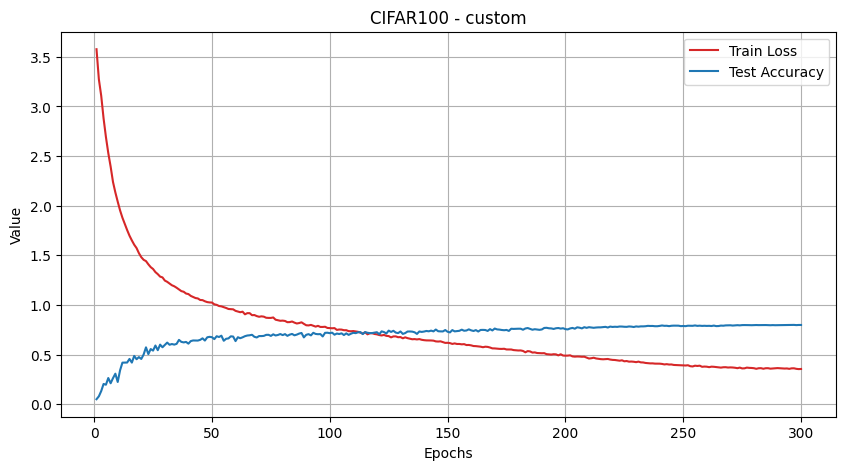

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', color='tab:red')
plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy', color='tab:blue')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title(f'{DATASET_NAME} - {DATASET_TYPE}')
plt.legend()
plt.grid(True)
plt.show()

## Evaluate the model on Testset

In [12]:
import torch
import numpy as np

# Evaluate the CIFAR-10 dataset
correct = 0
total = 0

with torch.no_grad():
    net.eval()
    for images, labels in baseline_testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    if total == 0:
        print('No images found for CIFAR-10 dataset.')
    else:
        cifar10_accuracy = 100 * correct / total
        print(f'Accuracy of the network on the CIFAR-10 test dataset: {cifar10_accuracy:.2f} %')

if not tpu:
    # Clear GPU memory
    torch.cuda.empty_cache()

    # Clear CPU memory
    torch.cuda.ipc_collect()

# Define the list of corruptions
corruptions = ['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur', 'glass_blur', 
               'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog', 'brightness', 
               'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression', 
               'speckle_noise', 'gaussian_blur', 'spatter', 'saturate']

# Define the batch size
batch_size = 256 

# Create an empty dictionary to store corrupted datasets
corrupted_datasets = {}

# Prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# List to store average accuracies for each corruption dataset
average_accuracies = []

# Loop over corruptions, loading and testing all 5 severity levels of each corruption dataset
for corruption in corruptions:
    print(f"Testing on corruption: {corruption}")

    # Load and test datasets for all 5 severity levels of the current corruption
    try:
        if DATASET_NAME=='CIFAR10':
            np_data_c = np.load(f'/kaggle/input/cifar-c/CIFAR-10-C/{corruption}.npy')
        elif DATASET_NAME=='CIFAR100':
            np_data_c = np.load(f'/kaggle/input/cifar-100-c/{corruption}.npy')
        else:
            raise ValueError(f'Corruption dataset {DATASET_NAME} not loaded')
            
        np_data_c_splits = np.array_split(np_data_c, 5)
        
        # List to store accuracies of all severity levels for averaging
        accuracies = []

        for i, np_data_c_split in enumerate(np_data_c_splits):
            custom_dataset = CustomDataset(np_data_c_split, baseline_testset, resize=True)
            custom_dataloader = torch.utils.data.DataLoader(custom_dataset, batch_size=batch_size, shuffle=False)

            # Testing loop for the current corruption dataset split
            correct = 0
            total = 0

            with torch.no_grad():
                images_loaded = 0  # Counter for images loaded for the current corruption
                for images, labels in custom_dataloader:
                    images_loaded += len(images)  # Increment the counter by the number of images loaded
                    images, labels = images.to(device), labels.to(device)
                    # Calculate outputs by running images through the network
                    outputs = net(images)
                    # The class with the highest energy is chosen as prediction
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                if total == 0:
                    print(f'No images found for {corruption} dataset split {i+1}.')
                else:
                    accuracy = 100 * correct / total
                    print(f'Accuracy of the network on {corruption} dataset split {i+1}: {accuracy:.2f} %')
                    accuracies.append(accuracy)

                # Print the number of images loaded for the current corruption dataset split
                #print(f"Images loaded for {corruption} dataset split {i+1}: {images_loaded}")
                
                if not tpu:
                    # Clear GPU memory
                    torch.cuda.empty_cache()
                    # Clear CPU memory
                    torch.cuda.ipc_collect()

                # Delete variables to free up memory
                del custom_dataset
                del custom_dataloader

        # Calculate and print the average accuracy for the corruption dataset
        if accuracies:
            average_accuracy = sum(accuracies) / len(accuracies)
            average_accuracies.append(average_accuracy)
            print(f'Average accuracy for {corruption} dataset: {average_accuracy:.2f} %')

    except FileNotFoundError:
        print(f'Corruption {corruption} dataset not found.')
        continue

# Calculate and print the average robust accuracy
if average_accuracies:
    average_robust_accuracy = sum(average_accuracies) / len(average_accuracies)
    print(f'Average Robust Accuracy: {average_robust_accuracy:.2f} %')
else:
    print("No corrupt datasets found for evaluation.")

Accuracy of the network on the CIFAR-10 test dataset: 79.89 %
Testing on corruption: gaussian_noise
Accuracy of the network on gaussian_noise dataset split 1: 58.19 %
Accuracy of the network on gaussian_noise dataset split 2: 40.99 %
Accuracy of the network on gaussian_noise dataset split 3: 27.42 %
Accuracy of the network on gaussian_noise dataset split 4: 21.86 %
Accuracy of the network on gaussian_noise dataset split 5: 18.09 %
Average accuracy for gaussian_noise dataset: 33.31 %
Testing on corruption: shot_noise
Accuracy of the network on shot_noise dataset split 1: 66.61 %
Accuracy of the network on shot_noise dataset split 2: 57.29 %
Accuracy of the network on shot_noise dataset split 3: 37.50 %
Accuracy of the network on shot_noise dataset split 4: 31.13 %
Accuracy of the network on shot_noise dataset split 5: 22.25 %
Average accuracy for shot_noise dataset: 42.96 %
Testing on corruption: impulse_noise
Accuracy of the network on impulse_noise dataset split 1: 76.10 %
Accuracy of

In [13]:
# # Load the model checkpoint
# net = WideResNet_28_4(num_classes=100)
# checkpoint_path = '/kaggle/working/MasterArbeit/models/cifar100_net_ta_pytorch_200.pth'
# checkpoint = torch.load(checkpoint_path)
# net.load_state_dict(checkpoint, strict=False)
# net.to(device)

# import torch
# import numpy as np


# # Evaluate the CIFAR-10 dataset
# correct = 0
# total = 0

# with torch.no_grad():
#     net.eval()
#     for images, labels in baseline_testloader:
#         images, labels = images.to(device), labels.to(device)
#         outputs = net(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

#     if total == 0:
#         print('No images found for CIFAR-10 dataset.')
#     else:
#         cifar10_accuracy = 100 * correct / total
#         print(f'Accuracy of the network on the CIFAR-10 test dataset: {cifar10_accuracy:.2f} %')
        
# if not tpu:
#     # Clear GPU memory
#     torch.cuda.empty_cache()

#     # Clear CPU memory
#     torch.cuda.ipc_collect()

# # Define the list of corruptions
# corruptions = ['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur', 'glass_blur', 
#                'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog', 'brightness', 
#                'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression', 
#                'speckle_noise', 'gaussian_blur', 'spatter', 'saturate']

# # Define the batch size
# batch_size = 256 

# # Create an empty dictionary to store corrupted datasets
# corrupted_datasets = {}

# # Prepare to count predictions for each class
# correct_pred = {classname: 0 for classname in classes}
# total_pred = {classname: 0 for classname in classes}

# # List to store average accuracies for each corruption dataset
# average_accuracies = []

# # Loop over corruptions, loading and testing all 5 severity levels of each corruption dataset
# for corruption in corruptions:
#     print(f"Testing on corruption: {corruption}")

#     # Load and test datasets for all 5 severity levels of the current corruption
#     try:
#         if DATASET_NAME=='CIFAR10':
#             np_data_c = np.load(f'/kaggle/input/cifar-c/CIFAR-10-C/{corruption}.npy')
#         elif DATASET_NAME=='CIFAR100':
#             np_data_c = np.load(f'/kaggle/input/cifar-100-c/{corruption}.npy')
#         else:
#             raise ValueError(f'Corruption dataset {DATASET_NAME} not loaded')
#         np_data_c_splits = np.array_split(np_data_c, 5)
        
#         # List to store accuracies of all severity levels for averaging
#         accuracies = []

#         for i, np_data_c_split in enumerate(np_data_c_splits):
#             custom_dataset = CustomDataset(np_data_c_split, baseline_testset, resize=True)
#             custom_dataloader = torch.utils.data.DataLoader(custom_dataset, batch_size=batch_size, shuffle=False)

#             # Testing loop for the current corruption dataset split
#             correct = 0
#             total = 0

#             with torch.no_grad():
#                 images_loaded = 0  # Counter for images loaded for the current corruption
#                 for images, labels in custom_dataloader:
#                     images_loaded += len(images)  # Increment the counter by the number of images loaded
#                     images, labels = images.to(device), labels.to(device)
#                     # Calculate outputs by running images through the network
#                     outputs = net(images)
#                     # The class with the highest energy is chosen as prediction
#                     _, predicted = torch.max(outputs.data, 1)
#                     total += labels.size(0)
#                     correct += (predicted == labels).sum().item()

#                 if total == 0:
#                     print(f'No images found for {corruption} dataset split {i+1}.')
#                 else:
#                     accuracy = 100 * correct / total
#                     print(f'Accuracy of the network on {corruption} dataset split {i+1}: {accuracy:.2f} %')
#                     accuracies.append(accuracy)

#                 # Print the number of images loaded for the current corruption dataset split
#                 #print(f"Images loaded for {corruption} dataset split {i+1}: {images_loaded}")
                
#                 if not tpu:
#                     # Clear GPU memory
#                     torch.cuda.empty_cache()
#                     # Clear CPU memory
#                     torch.cuda.ipc_collect()

#                 # Delete variables to free up memory
#                 del custom_dataset
#                 del custom_dataloader

#         # Calculate and print the average accuracy for the corruption dataset
#         if accuracies:
#             average_accuracy = sum(accuracies) / len(accuracies)
#             average_accuracies.append(average_accuracy)
#             print(f'Average accuracy for {corruption} dataset: {average_accuracy:.2f} %')

#     except FileNotFoundError:
#         print(f'Corruption {corruption} dataset not found.')
#         continue

# # Calculate and print the average robust accuracy
# if average_accuracies:
#     average_robust_accuracy = sum(average_accuracies) / len(average_accuracies)
#     print(f'Average Robust Accuracy: {average_robust_accuracy:.2f} %')
# else:
#     print("No corrupt datasets found for evaluation.")